In [1]:
!pip install keras_applications
!pip install tf_notification_callback
!pip install livelossplot
# raw keras
from livelossplot import PlotLossesKeras
plotlosses = PlotLossesKeras()
from tf_notification_callback import TelegramCallback
telegram_callback = TelegramCallback('1349030414:AAGOY3VPrppCE43qVCLcBP7RbmlC2heV7gY',
                                     '-399009598',
                            f'Emotion Recoginition Model_19thOct2020',
                           ['loss', 'val_loss'],
                            ['accuracy', 'val_accuracy'],
                           getSummary=False)

     |████████████████████████████████| 50 kB 269 kB/s 
     |████████████████████████████████| 404 kB 403 kB/s 
     |████████████████████████████████| 428 kB 2.8 MB/s 
     |████████████████████████████████| 58 kB 2.5 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.0.2
    Uninstalling tornado-5.0.2:
      Successfully uninstalled tornado-5.0.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

jupyterlab-git 0.10.0 requires nbdime<2.0.0,>=1.1.0, but you'll have nbdime 2.0.0 which is incompatible.
dask-xgboost 0.1.11 requires xgboost<=0.90, but you'll have xgboost 1.2.1 which is incompatible.


In [2]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-4kymsujn
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8310 sha256=17d725432f65cc09303b7be2c5a417b71b79ded9c11d3f401792a3aec26af9bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-l7c7u5ja/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface


In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os

In [4]:
PATH = "../input/kdef-200/output"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             image_size=IMG_SIZE)

Found 3910 files belonging to 7 classes.


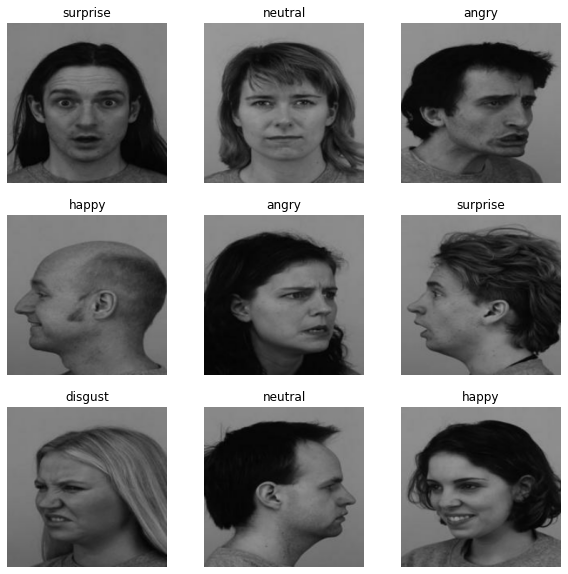

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [7]:
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
	# rotation_range=25,
	# zoom_range=0.1,
	# width_shift_range=0.1,
	# height_shift_range=0.1,
	# shear_range=0.2,
	horizontal_flip=True,
  )
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([0.485, 0.456, 0.406], dtype="float32")
std = np.array([0.229, 0.224, 0.225],dtype="float32")
trainAug.mean = mean
valAug.mean = mean
trainAug.std = std
valAug.std = std

In [8]:
trainGen = trainAug.flow_from_directory( 
	train_dir,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE)
# initialize the validation generator
valGen = valAug.flow_from_directory(
	validation_dir,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=BATCH_SIZE)

Found 3910 images belonging to 7 classes.
Found 979 images belonging to 7 classes.


In [9]:
from tensorflow.keras.layers import AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam, RMSprop
#from tensorflow.keras.applications import ResNet50,VGG16
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.metrics import classification_report
from keras_vggface.vggface import VGGFace

In [10]:
print("preparing model...")
# baseModel = VGG16(weights="imagenet", include_top=False,
# 	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
baseModel = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg')
#base model and freezing
baseModel.trainable = False
headModel = baseModel.output
# headModel = GlobalAveragePooling2D()(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(trainGen.num_classes, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()

preparing model...
58916864/58909280 [==============================] - 2s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
____________________________________

In [11]:
def scheduler(epoch, lr):
  if epoch!=0 and epoch%10==0:
    lr = lr*0.8
  return lr

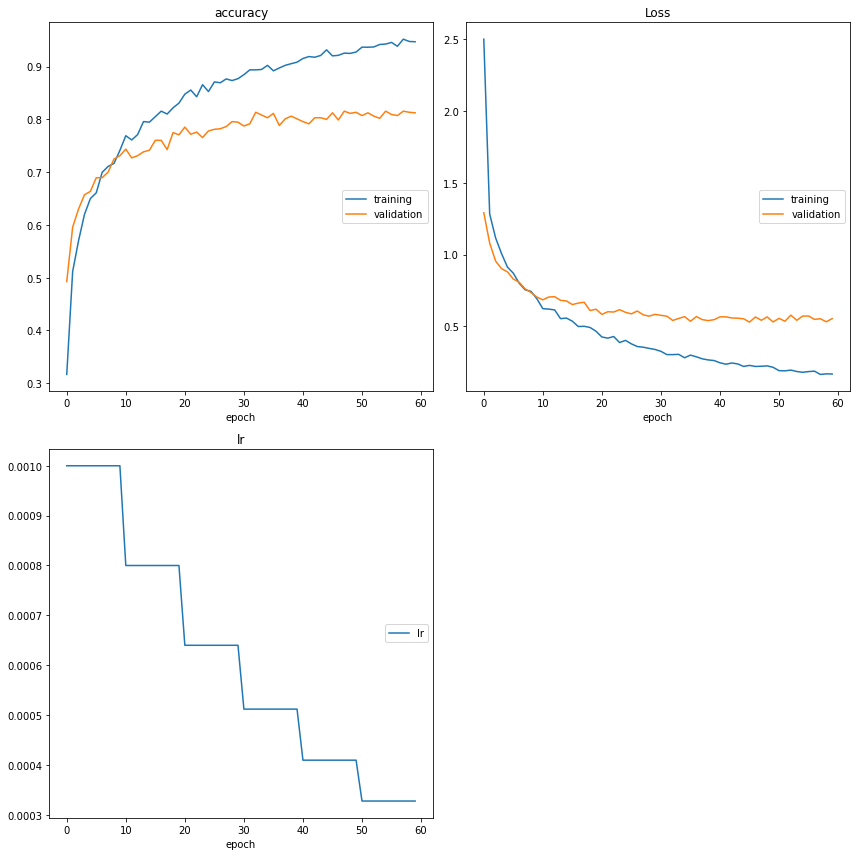

accuracy
	training         	 (min:    0.317, max:    0.952, cur:    0.947)
	validation       	 (min:    0.493, max:    0.816, cur:    0.812)
Loss
	training         	 (min:    0.165, max:    2.501, cur:    0.168)
	validation       	 (min:    0.530, max:    1.291, cur:    0.554)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
61/61 [==============================] - 15s 244ms/step - loss: 0.1684 - accuracy: 0.9472 - val_loss: 0.5542 - val_accuracy: 0.8125


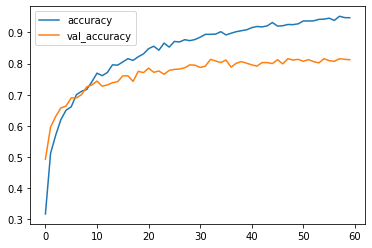

In [12]:
epoch = 60
# compile the model
#opt = SGD(lr=0.001, momentum=0.9)
opt = Adam(lr=0.001)
#opt = RMSprop(lr=0.001, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
checkpoint = ModelCheckpoint("model_weights.h5",save_weights_only=True)
steps = trainGen.n//trainGen.batch_size
val_steps = valGen.n//valGen.batch_size
#scheduler = ReduceLROnPlateau(monitor='val_loss',factor = 0.5 , patience=1 , mode='auto')
call_back = [LearningRateScheduler(scheduler),checkpoint,telegram_callback,plotlosses]
# train the model
print("training model...")
H = model.fit(
	x=trainGen,
	steps_per_epoch=steps,
	validation_data=valGen,
	validation_steps=val_steps,
  callbacks = call_back,
	epochs=epoch)

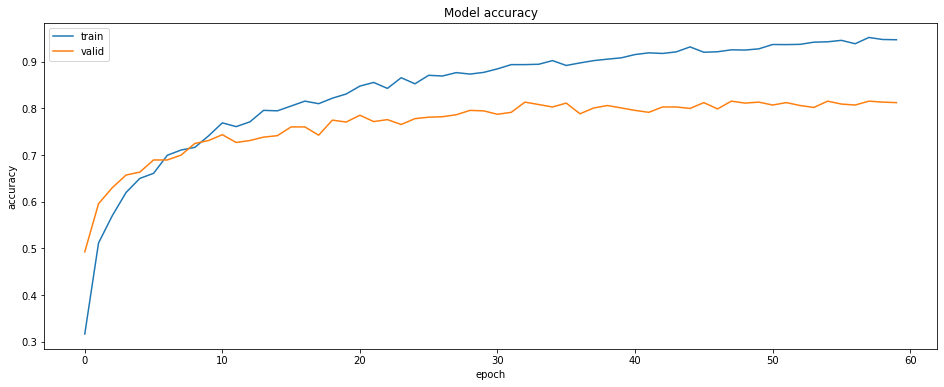

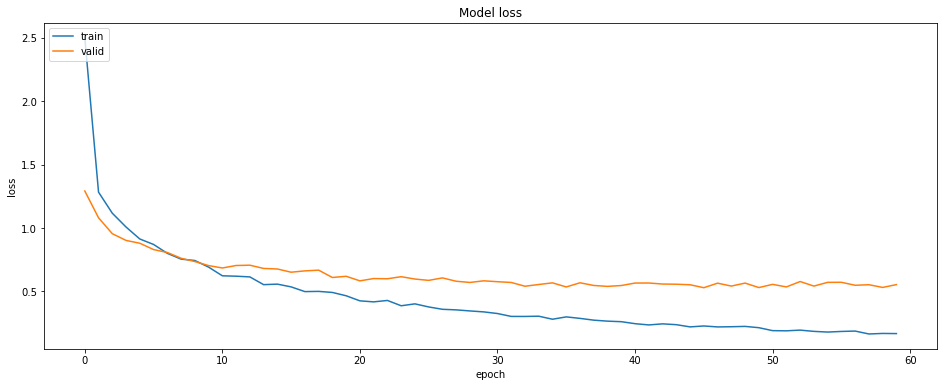

In [13]:
def display_history(history):
    """Summarize history for accuracy and loss.
    """
    plt.figure(figsize=(16,6))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    plt.figure(figsize=(16,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
#If you need...
display_history(H)

In [14]:
model.load_weights("model_weights.h5")

In [15]:
testGen = valGen

In [16]:
testGen.reset()
predIdxs = model.predict(testGen,
	steps=(testGen.n // BATCH_SIZE) + 1)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))


              precision    recall  f1-score   support

       angry       0.77      0.85      0.81       140
     disgust       0.81      0.75      0.78       139
        fear       0.79      0.59      0.68       140
       happy       0.93      0.92      0.92       140
     neutral       0.82      0.90      0.86       140
         sad       0.71      0.79      0.75       140
    surprise       0.87      0.89      0.88       140

    accuracy                           0.81       979
   macro avg       0.81      0.81      0.81       979
weighted avg       0.81      0.81      0.81       979

